In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, LSTM, GRU
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [171]:
df=pd.read_csv('./HDFC.csv',index_col='Date',parse_dates=True)

In [172]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HDFC,EQ,271.75,293.50,293.50,293.50,293.50,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
2000-01-04,HDFC,EQ,293.50,317.00,317.00,297.00,304.00,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2000-01-05,HDFC,EQ,304.05,290.00,303.90,285.00,295.00,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
2000-01-06,HDFC,EQ,292.80,301.00,314.00,295.00,296.00,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
2000-01-07,HDFC,EQ,296.45,290.00,296.35,281.00,287.10,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327


In [173]:
df['Date']=df.index

In [174]:
start_date='2016-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [175]:
df=df.loc[mask]

In [176]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [177]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [178]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [179]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [180]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (1187, 50) Y.shape (1187,)


In [181]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

LSTM+CNN

In [182]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPool1D()(x)
x=Dense(1)(x)
model_lstm_cnn=Model(i,x)
model_lstm_cnn.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 48, 25)            100       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 24, 25)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d_9 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_39 (Dense)            (None, 1)                 51  

In [183]:
check_point_lstm_cnn=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [184]:
model_lstm_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [185]:
r=model_lstm_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm_cnn]
)

Epoch 1/100
26/26 [==============================] - 1s 15ms/step - loss: 553.5519 - mae: 17.7081 - mse: 553.5519 - val_loss: 2527.5547 - val_mae: 34.7151 - val_mse: 2527.5547
Epoch 2/100
26/26 [==============================] - 0s 10ms/step - loss: 547.2558 - mae: 17.6216 - mse: 547.2558 - val_loss: 2512.3318 - val_mae: 34.5304 - val_mse: 2512.3318
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 542.0703 - mae: 17.5894 - mse: 542.0703 - val_loss: 2514.8582 - val_mae: 34.5382 - val_mse: 2514.8582
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 537.4230 - mae: 17.5410 - mse: 537.4230 - val_loss: 2514.4443 - val_mae: 34.5355 - val_mse: 2514.4443
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 536.4875 - mae: 17.5273 - mse: 536.4875 - val_loss: 2516.5088 - val_mae: 34.5250 - val_mse: 2516.5088
Epoch 6/100
26/26 [==============================] - 0s 8ms/step - loss: 537.0909 - mae: 17.5664 - mse: 537.0909 - val_loss

LSTM+GRU

In [186]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=GRU(200,return_sequences=True)(x)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm_gru=Model(i,x)
model_lstm_gru.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 lstm_20 (LSTM)              (None, 50, 200)           161600    
                                                                 
 lstm_21 (LSTM)              (None, 50, 200)           320800    
                                                                 
 dense_40 (Dense)            (None, 50, 100)           20100     
                                                                 
 dense_41 (Dense)            (None, 50, 50)            5050      
                                                                 
 gru_10 (GRU)                (None, 50, 200)           151200    
                                                                 
 gru_11 (GRU)                (None, 50, 200)           241

In [187]:
check_point_lstm_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [188]:
model_lstm_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [189]:
r=model_lstm_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm_gru]
)

Epoch 1/100
26/26 [==============================] - 23s 606ms/step - loss: 543.3048 - mae: 17.6327 - mse: 543.3048 - val_loss: 2515.1643 - val_mae: 34.4919 - val_mse: 2515.1643
Epoch 2/100
26/26 [==============================] - 14s 539ms/step - loss: 542.9067 - mae: 17.6258 - mse: 542.9067 - val_loss: 2515.3035 - val_mae: 34.4778 - val_mse: 2515.3035
Epoch 3/100
26/26 [==============================] - 14s 541ms/step - loss: 542.2609 - mae: 17.6290 - mse: 542.2609 - val_loss: 2514.8062 - val_mae: 34.4732 - val_mse: 2514.8062
Epoch 4/100
26/26 [==============================] - 14s 543ms/step - loss: 541.4482 - mae: 17.6259 - mse: 541.4482 - val_loss: 2514.2698 - val_mae: 34.4518 - val_mse: 2514.2698
Epoch 5/100
26/26 [==============================] - 14s 540ms/step - loss: 541.7368 - mae: 17.6348 - mse: 541.7368 - val_loss: 2513.2346 - val_mae: 34.4593 - val_mse: 2513.2346
Epoch 6/100
26/26 [==============================] - 14s 537ms/step - loss: 542.0893 - mae: 17.6565 - mse: 542

Predictions



In [190]:
train_idx[:T+1]=False

In [191]:
Ptrain_lstm_cnn=model_lstm_cnn.predict(Xtrain).flatten()
Ptest_lstm_cnn=model_lstm_cnn.predict(Xtest).flatten()

In [192]:
Ptrain_lstm_gru=model_lstm_gru.predict(Xtrain).flatten()
Ptest_lstm_gru=model_lstm_gru.predict(Xtest).flatten()

In [ ]:
df.loc[train_idx,'Diff LSTM+CNN train prediction']=Ptrain_lstm_cnn
df.loc[test_idx,'Diff LSTM+CNN test prediction']=Ptest_lstm_cnn

In [193]:
df.loc[train_idx,'Diff LSTM+GRU train prediction']=Ptrain_lstm_gru
df.loc[test_idx,'Diff LSTM+GRU test prediction']=Ptest_lstm_gru

In [194]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [195]:
last_train=train.iloc[-1]['Prev Close']

In [196]:
df.loc[train_idx,'train_LSTM_CNN']=prev[train_idx]+Ptrain_lstm_cnn
df.loc[test_idx,'Prediction_LSTM_CNN']=prev[test_idx]+Ptest_lstm_cnn

In [197]:
df.loc[train_idx,'train_LSTM_GRU']=prev[train_idx]+Ptrain_lstm_gru
df.loc[test_idx,'Prediction_LSTM_GRU']=prev[test_idx]+Ptest_lstm_gru

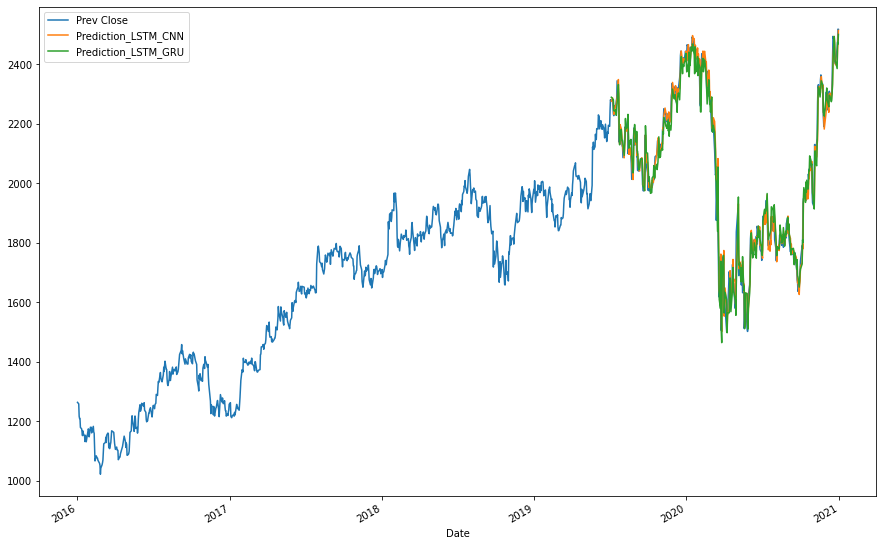

In [198]:
df[['Prev Close' ,'Prediction_LSTM_CNN','Prediction_LSTM_GRU']].plot(figsize=(15,10));

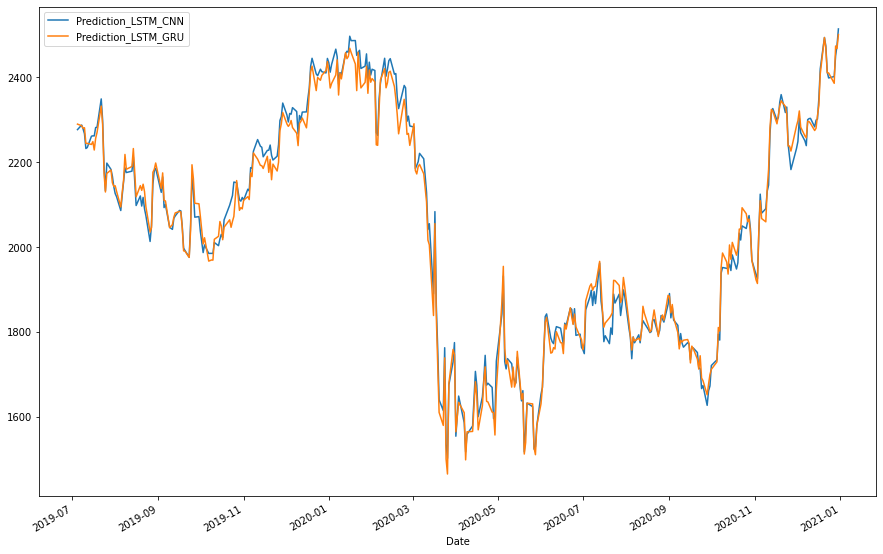

In [199]:
df[['Prediction_LSTM_CNN','Prediction_LSTM_GRU']].plot(figsize=(15,10));

In [200]:
pred_lstm_cnn=df['Prediction_LSTM_CNN']
pred_lstm_cnn.dropna(inplace=True)

In [201]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm_cnn))
print(rmse)

51.66848884208101


In [202]:
error=mean_absolute_error(test['Prev Close'],pred_lstm_cnn)
print(error)

35.26864342204324


In [203]:
r2_score(test['Prev Close'],pred_lstm_cnn)

0.9634426254455425

In [204]:
pred_lstm_gru=df['Prediction_LSTM_GRU']
pred_lstm_gru.dropna(inplace=True)

In [205]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm_cnn))
print(rmse)

51.66848884208101


In [206]:
error=mean_absolute_error(test['Prev Close'],pred_lstm_gru)
print(error)

40.004758715941094


In [207]:
r2_score(test['Prev Close'],pred_lstm_gru)

0.9578413294935544